In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

from utils.classing import get_target_by_classing
from utils.data import (
    FilePaths,
    correlation_coefficient,
    display_image,
    mean_bias_error,
    read_image_file,
    rmse,
)
from utils.deep import (
    RegressionDataset,
    Regressor,
    ToTensor,
    stack_inputs,
    train
)
from utils.models import (
    albedo_polynomial_fit,
    albedo_polynomial_sharpening,
    linear_fit,
    linear_sharpening,
    multi_linear_fit,
    multi_linear_sharpening,
    replace_thresholded_pixels,
)
from utils.patching import get_fine_reconstruction_from_patches
from utils.residualcorrection import (
    upscale_coarse,
    upscale_coarse_krig,
    resid_calc_classic,
    resid_calc_mean
)

In [2]:
n_c = 30
n_h = 150

In [3]:
I_C = read_image_file(FilePaths.INDEX_C)
I_H = read_image_file(FilePaths.INDEX_H)
T_C = read_image_file(FilePaths.TEMP_C)
T_H = read_image_file(FilePaths.TEMP_H)
A_C = read_image_file(FilePaths.ALBEDO_C)
A_H = read_image_file(FilePaths.ALBEDO_H)
C_C = read_image_file(FilePaths.CLASS_C)
C_H = read_image_file(FilePaths.CLASS_H)

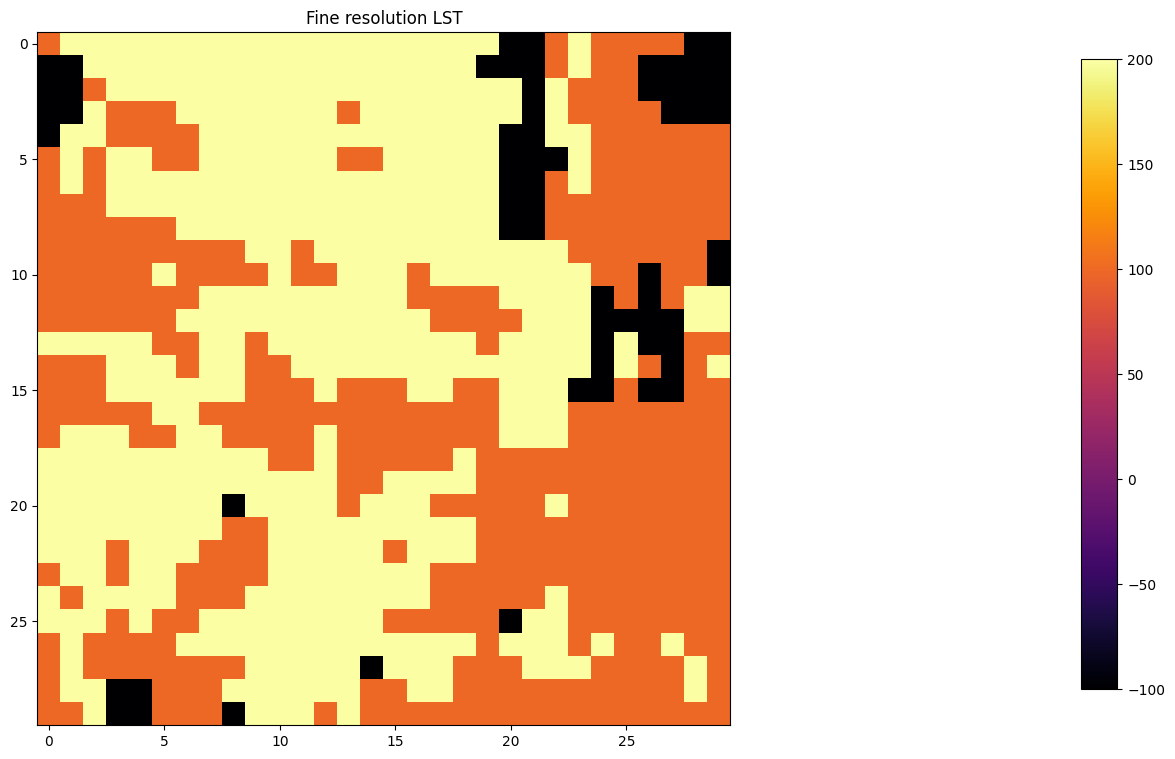

In [4]:
display_image(C_C)

In [5]:
ALBEDO_LOW = T_C.min() - 5
ALBEDO_HIGH = T_C.max() + 5

## Linear Fit

In [6]:
linear_fit_res = linear_fit(I_C, T_C)

linear_pred = linear_sharpening([I_C], linear_fit_res)
linear_sharp = linear_sharpening([I_H], linear_fit_res)

linear_resids = resid_calc_classic(T_C, linear_pred)

upscaled_linear_linear_resids = upscale_coarse(linear_resids)
upscaled_linear_krig_resids = upscale_coarse_krig(linear_resids)

linear_sharp_rc_linaer = linear_sharp + upscaled_linear_linear_resids
linear_sharp_rc_krig   = linear_sharp + upscaled_linear_krig_resids

linear_rc_linear_rmse = rmse(linear_sharp_rc_linaer, T_H)
linear_rc_krig = rmse(linear_sharp_rc_krig, T_H)

print("Linear Model RMSEs")
print("Residual Correction - Linear : ", linear_rc_linear_rmse)
print("Residual Correction - Krig   : ", linear_rc_krig)

Linear Model RMSEs
Residual Correction - Linear :  9.177208550747284
Residual Correction - Krig   :  9.741766828649471


## Multi-Linear Fit

In [7]:
multi_model = multi_linear_fit([I_C, A_C], T_C)

multi_pred = multi_linear_sharpening([I_C.flatten(), A_C.flatten()], multi_model, n_c)
multi_sharp = multi_linear_sharpening([I_H.flatten(), A_H.flatten()], multi_model, n_h)

multi_resids = resid_calc_classic(T_C, multi_pred)

upscaled_multi_linear_resids = upscale_coarse(multi_resids)
upscaled_multi_krig_resids = upscale_coarse_krig(multi_resids)

multi_sharp_rc_linear = multi_sharp + upscaled_multi_linear_resids
multi_sharp_rc_krig = multi_sharp + upscaled_multi_krig_resids


multi_rc_linear_rmse = rmse(multi_sharp_rc_linear, T_H)
multi_rc_krig = rmse(multi_sharp_rc_krig, T_H)

print("Multi Linear Model RMSEs")
print("Residual Correction - Linear : ", multi_rc_linear_rmse)
print("Residual Correction - Krig   : ", multi_rc_krig)

Multi Linear Model RMSEs
Residual Correction - Linear :  9.60510883824584
Residual Correction - Krig   :  21.761528665589697


## Polynomial Fit

In [8]:
poly_model = albedo_polynomial_fit([I_C, A_C], T_C)

poly_pred = albedo_polynomial_sharpening([I_C, A_C], poly_model, n_c, ALBEDO_HIGH, ALBEDO_LOW)
poly_sharp = albedo_polynomial_sharpening([I_H, A_H], poly_model, n_h, ALBEDO_HIGH, ALBEDO_LOW)

poly_resids = resid_calc_mean(T_C, poly_sharp)

upscaled_poly_linear_resids = upscale_coarse(poly_resids)
upscaled_poly_krig_resids = upscale_coarse_krig(poly_resids)

poly_sharp_rc_linear = poly_sharp + upscaled_poly_linear_resids
poly_sharp_rc_krig = poly_sharp + upscaled_poly_krig_resids

poly_rc_linear_rmse = rmse(poly_sharp_rc_linear, T_H)
poly_rc_krig = rmse(poly_sharp_rc_krig, T_H)

print("Albedo Polynomial Model RMSEs")
print("Residual Correction - Linear : ", poly_rc_linear_rmse)
print("Residual Correction - Krig   : ", poly_rc_krig)

Albedo Polynomial Model RMSEs
Residual Correction - Linear :  16.291971982964252
Residual Correction - Krig   :  25.248798930810356


## Patching

In [9]:
patch_size = 5
stride = patch_size
coarse_image_temp = T_C

#### Linear Patching

In [10]:
lin_coarse_inputs = [I_C]
lin_fine_inputs = [I_H]

linear_patched, linear_patched_resids = get_fine_reconstruction_from_patches(
    lin_coarse_inputs, lin_fine_inputs, coarse_image_temp, linear_fit, linear_sharpening, patch_size, stride,
)

linear_patched_rc_linear = linear_patched + upscale_coarse(linear_patched_resids)
linear_patched_rc_krig = linear_patched + upscale_coarse_krig(linear_patched_resids)

lin_patched_rc_linear_rmse = rmse(linear_patched_rc_linear, T_H)
lin_patched_rc_krig_rmse = rmse(linear_patched_rc_krig, T_H)

print("Linear Patched Model RMSEs")
print("Residual Correction - Linear : ", lin_patched_rc_linear_rmse)
print("Residual Correction - Krig   : ", lin_patched_rc_krig_rmse)

Linear Patched Model RMSEs
Residual Correction - Linear :  9.860210475391769
Residual Correction - Krig   :  15.647707829282272


#### Multi Linear Patching

In [11]:
multi_coarse_inputs = [I_C, A_C]
multi_fine_inputs = [I_H, A_H]

multi_patched, multi_patched_resids = get_fine_reconstruction_from_patches(
    multi_coarse_inputs, multi_fine_inputs, coarse_image_temp, multi_linear_fit, multi_linear_sharpening, patch_size, stride,
)

multi_patched_rc_linear = multi_patched + upscale_coarse(multi_patched_resids)
multi_patched_rc_krig = multi_patched + upscale_coarse_krig(multi_patched_resids)


multi_patched_rc_linear_rmse = rmse(multi_patched_rc_linear, T_H)
multi_patched_rc_krig_rmse = rmse(multi_patched_rc_krig, T_H)

print("Multi Patched Model RMSEs")
print("Residual Correction - Linear : ", multi_patched_rc_linear_rmse)
print("Residual Correction - Krig   : ", multi_patched_rc_krig_rmse)

Multi Patched Model RMSEs
Residual Correction - Linear :  9.654868025514062
Residual Correction - Krig   :  14.29652704867315


#### Polynomial Patching

In [12]:
poly_coarse_inputs = [I_C, A_C]
poly_fine_inputs = [I_H, A_H]

poly_patched, poly_patched_resids = get_fine_reconstruction_from_patches(
    poly_coarse_inputs, poly_fine_inputs, coarse_image_temp,
    albedo_polynomial_fit, albedo_polynomial_sharpening,
    patch_size, stride, ALBEDO_HIGH, ALBEDO_LOW
)

poly_patched_rc_linear = poly_patched + upscale_coarse(poly_patched_resids)
poly_patched_rc_krig = poly_patched + upscale_coarse_krig(poly_patched_resids)

poly_patched_rc_linear_rmse = rmse(poly_patched_rc_linear, T_H)
poly_patched_rc_krig_rmse = rmse(poly_patched_rc_krig, T_H)

print("Poly Patched Model RMSEs")
print("Residual Correction - Linear : ", poly_patched_rc_linear_rmse)
print("Residual Correction - Krig   : ", poly_patched_rc_krig_rmse)

Poly Patched Model RMSEs
Residual Correction - Linear :  635686.4468785855
Residual Correction - Krig   :  637852.3571712539


## Classing

In [13]:
coarse_image_temp = T_C

classes = np.unique(C_C)
coarse_masks = {}
fine_masks = {}

for class_ in classes:
    coarse_masks[class_] = C_C == class_
    fine_masks[class_] = C_H == class_


#### Linear Classing

In [14]:
lin_coarse_inputs = [I_C]
lin_fine_inputs = [I_H]

linear_classed, linear_classes_resids = get_target_by_classing(
    lin_coarse_inputs, lin_fine_inputs, coarse_image_temp, coarse_masks, fine_masks, linear_fit, linear_sharpening,
)

lin_classed_rc_linear = linear_classed + upscale_coarse(linear_classes_resids)
lin_classed_rc_krig = linear_classed + upscale_coarse_krig(linear_classes_resids)

lin_classed_rc_linear_rmse = rmse(lin_classed_rc_linear, T_H)
lin_classed_rc_krig_rmse = rmse(lin_classed_rc_krig, T_H)

print("Linear Classed Model RMSEs")
print("Residual Correction - Linear : ", lin_classed_rc_linear_rmse)
print("Residual Correction - Krig   : ", lin_classed_rc_krig_rmse)

Linear Classed Model RMSEs
Residual Correction - Linear :  11.634007908299235
Residual Correction - Krig   :  12.304131679321127


RMSE by Class

In [15]:
sharp_class1 = lin_classed_rc_linear[fine_masks[-100]]
T_H_class1 = T_H[fine_masks[-100]]

sharp_class2 = lin_classed_rc_linear[fine_masks[100]]
T_H_class2 = T_H[fine_masks[100]]

sharp_class3 = lin_classed_rc_linear[fine_masks[200]]
T_H_class3 = T_H[fine_masks[200]]

print("Linear Classed Model RMSEs by Class")
print("RMSE Class 1 : ", rmse(sharp_class1, T_H_class1))
print("RMSE Class 2 : ", rmse(sharp_class2, T_H_class2))
print("RMSE Class 3 : ", rmse(sharp_class3, T_H_class3))

Linear Classed Model RMSEs by Class
RMSE Class 1 :  18.451799036648907
RMSE Class 2 :  7.533752975333412
RMSE Class 3 :  12.734455418761495


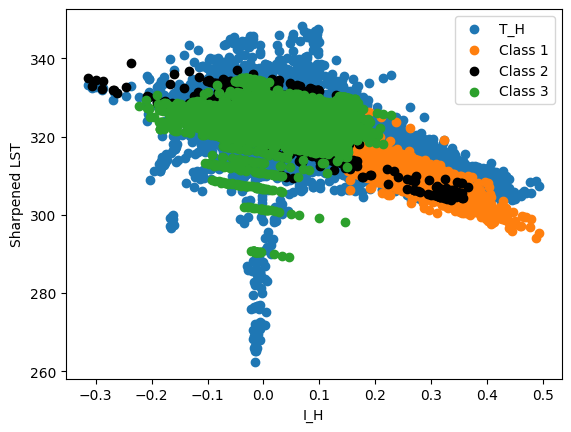

In [16]:
import matplotlib.pyplot as plt 

I_H_class1 = I_H[fine_masks[-100]]
I_H_class2 = I_H[fine_masks[100]]
I_H_class3 = I_H[fine_masks[200]]

plt.scatter(I_H, T_H, label="T_H")
plt.scatter(I_H_class1, sharp_class1, label="Class 1")
plt.scatter(I_H_class2, sharp_class2, label="Class 2", c="black")
plt.scatter(I_H_class3, sharp_class3, label="Class 3")
plt.xlabel("I_H")
plt.ylabel("Sharpened LST")
plt.legend()

Multi Linear Classing

In [17]:
multi_coarse_inputs = [I_C, A_C]
multi_fine_inputs = [I_H, A_H]

multi_classed, multi_classes_resids = get_target_by_classing(
    multi_coarse_inputs, multi_fine_inputs, coarse_image_temp, coarse_masks, fine_masks, multi_linear_fit, multi_linear_sharpening,
)

multi_classed_rc_linear = multi_classed + upscale_coarse(multi_classes_resids)
multi_classed_rc_krig = multi_classed + upscale_coarse_krig(multi_classes_resids)


multi_classed_rc_linear_rmse = rmse(multi_classed_rc_linear, T_H)
multi_classed_rc_krig_rmse = rmse(multi_classed_rc_krig, T_H)

print("Multi Classed Model RMSEs")
print("Residual Correction - Linear : ", multi_classed_rc_linear_rmse)
print("Residual Correction - Krig   : ", multi_classed_rc_krig_rmse)

Multi Classed Model RMSEs
Residual Correction - Linear :  12.267317158884632
Residual Correction - Krig   :  21.831079429835018


#### Polynomial Classing

In [18]:
poly_coarse_inputs = [I_C, A_C]
poly_fine_inputs = [I_H, A_H]

poly_classed, poly_classes_resids = get_target_by_classing(
    poly_coarse_inputs, poly_fine_inputs, coarse_image_temp, coarse_masks, fine_masks,
    albedo_polynomial_fit, albedo_polynomial_sharpening,
    ALBEDO_HIGH, ALBEDO_LOW,
)

poly_classed = replace_thresholded_pixels(poly_classed, ALBEDO_HIGH, ALBEDO_LOW)
                                          
poly_classed_rc_linear = multi_classed + upscale_coarse(poly_classes_resids)
poly_classed_rc_krig = multi_classed + upscale_coarse_krig(poly_classes_resids)


poly_classed_rc_linear_rmse = rmse(poly_classed_rc_linear, T_H)
poly_classed_rc_krig_rmse = rmse(poly_classed_rc_krig, T_H)

print("Poly Classed Model RMSEs")
print("Residual Correction - Linear : ", poly_classed_rc_linear_rmse)
print("Residual Correction - Krig   : ", poly_classed_rc_krig_rmse)

Poly Classed Model RMSEs
Residual Correction - Linear :  14.481339060516433
Residual Correction - Krig   :  22.62888566503071
